In [3]:
import torch
from torch import nn
import numpy as np

# 所有的输入均建立在batch上！！！

gtboxs：[batch,对应图片真实锚框个数,类别+真实锚框坐标]

anchors：[batch,锚框个数,四个坐标]

锚框偏移量：[batch,center_x,center_y,h,w]

cls_preds(预测分类)：[batch,锚框个数,正类类别+负类]

off_anchors_preds(预测偏移量)：[batch,锚框个数，四个偏移量]

# 既保留主要函数的使用，又能单独使用每一个函数

In [4]:
'''锚框坐标转换函数（中间函数）'''
def corner_to_center(anchors):
    num_batch = anchors.shape[0] #获得锚框的批次
    centers = []
    for i in range(num_batch):
        x1,y1,x2,y2 = anchors[i,:,0],anchors[i,:,1],anchors[i,:,2],anchors[i,:,3]  #提取每个批次下的所有锚框的左上右下坐标
        center_x = (x1+x2)/2.   #转换中心坐标x
        center_y = (y1+y2)/2.   #转换中心坐标y
        h = y2-y1    #转换高
        w = x2-x1    #转换宽
        center = torch.stack((center_x,center_y,h,w),dim=1)
        centers.append(center)
    centers = torch.cat([*centers],dim=0).reshape(num_batch,-1,4)
    return centers

def center_to_corner(anchors):
    num_batch = anchors.shape[0]
    corners = []
    for i in range(num_batch):
        center_x,center_y,h,w = anchors[i,:,0],anchors[i,:,1],anchors[i,:,2],anchors[i,:,3]
        x1 = center_x-w/2.
        x2 = center_x+w/2.
        y1 = center_y-h/2.
        y2 = center_y+h/2.
        corner = torch.stack((x1,y1,x2,y2),dim=1)
        corners.append(corner)
    corners = torch.cat([*corners],dim=0).reshape(num_batch,-1,4)
    return corners

In [5]:
'''锚框创建函数(针对不同尺寸的图片的featuremap增加泛化性)'''
def build_anchors(featuremap,sizes,ratios,device,resize_w=1,resize_h=1):
    #size：根据featuremap尺寸将锚框调整到合适的大小
    #可通过resize_w和resize_h将锚框放缩到任意大小
    featuremap = featuremap.to(device)
    num_batch, num_anchors = featuremap.shape[0],len(sizes) * len(ratios)
    #获取批次和每个像素点锚框的个数
    sizes,ratios = torch.tensor(sizes,device=device),torch.tensor(ratios,device=device)
    #将sizes和ratios转化成tensor便于参与计算
    fmap_height,fmap_width = featuremap.shape[2],featuremap.shape[3]
    #获取featuremap的高和宽
    anchors = []
    off_h,off_w = 0.5,0.5
    #要把每一个锚框的中心点移到每一个像素点格子的中心，因此偏移量选择0.5
    for _ in range(num_batch):
        shift_y = torch.tensor([i + off_h for i in torch.arange(fmap_height,device=device)],device=device)/fmap_height
        shift_x = torch.tensor([i + off_w for i in torch.arange(fmap_width,device=device)],device=device)/fmap_width
        shift_X,shift_Y = torch.meshgrid(shift_x,shift_y)
        '''
        根据featuremap的高和宽遍历得到的就是每一个锚框的中心点的位置，再将中心点偏移0.5到像素点中心，然后再除以对应的高和宽归一化到(0,1]
        然后铺成网格
        '''
        anchors_h = (sizes[:,None]*torch.sqrt(ratios)/fmap_height).reshape(-1)
        anchors_w = (sizes[:,None]/torch.sqrt(ratios)/fmap_width).reshape(-1)
        #计算每个锚框的高和宽并按featuremap的高和宽比例缩小
        x1 = shift_X.reshape(-1,1)-anchors_w/2.
        y1 = shift_Y.reshape(-1,1)-anchors_h/2.
        x2 = shift_X.reshape(-1,1)+anchors_w/2.
        y2 = shift_Y.reshape(-1,1)+anchors_h/2.
        #计算锚框的corner型的四个坐标
        anchor = torch.stack((x1.reshape(-1),y1.reshape(-1),x2.reshape(-1),y2.reshape(-1)),dim=0).T
        anchors.append(anchor)
    anchors = torch.cat([*anchors],dim=0).reshape(num_batch,-1,4)*torch.tensor([resize_w,resize_h]*2,device=device)
    return anchors

In [6]:
'''iou函数(中间函数)'''
def iou(boxes1,boxes2,device):
    # 输入的boxes1和boxes2都是corner型
    assert ((len(boxes1.shape) == 3) & (len(boxes2.shape) == 3)),"boxes1或boxes2没有batch！"
    assert (boxes1.shape[0] == boxes2.shape[0]),"boxes1与boxes的batch不相同！"
    boxes1,boxes2 = boxes1.to(device),boxes2.to(device)
    num_batch = boxes1.shape[0]#获取批次
    num_boxes1,num_boxes2 = boxes1.shape[1],boxes2.shape[1]  #获取boxes1和boxes2的个数
    iou_areas = []
    for i in range(num_batch):
        boxes1_area = (boxes1[i,:,2]-boxes1[i,:,0])*(boxes1[i,:,3]-boxes1[i,:,1])
        boxes2_area = (boxes2[i,:,2]-boxes2[i,:,0])*(boxes2[i,:,3]-boxes2[i,:,1])
        #计算每个boxes的面积
        area = (boxes1_area[:,None]+boxes2_area).reshape(num_boxes1*num_boxes2,-1).reshape(1,-1)
        #将每个boxes1中的面积和boxes2中的面积相加，用于后面计算并面积
        upper_left = torch.max(boxes1[i,:,None,:2],boxes2[i,:,:2]).reshape(num_boxes1*num_boxes2,2)
        lower_right = torch.min(boxes1[i,:,None,2:],boxes2[i,:,2:]).reshape(num_boxes1*num_boxes2,2)
        #获得两个锚框相交时交锚框的左上右下坐标
        width = (lower_right[:,0]-upper_left[:,0]).clamp(min=0)
        height = (lower_right[:,1]-upper_left[:,1]).clamp(min=0)
        #利用前面获得的坐标计算锚框高和宽
        intersection_area = width*height.reshape(1,-1)
        union_area = area-intersection_area
        #计算锚框的交面积和并面积
        iou_area = intersection_area/union_area  #计算iou值
        iou_area[torch.isnan(iou_area)]=-1*np.inf    
        #如果出现锚框为一条线，当两条线计算iou值时会出现nan值，把nan变成inf来避免筛选，此情况只会出现在预测锚框和预测锚框之间
        iou_areas.append(iou_area)
    iou_areas = torch.cat([*iou_areas],dim=0).reshape(num_batch,num_boxes1,-1)
    return iou_areas

In [7]:
'''给锚框分配真实边界框（中间函数/主函数）'''
def assign_gtbox_to_anchor(anchors,gtboxs,device,threshold=0.5):
    anchors,gtboxs = anchors.to(device),gtboxs.to(device)
    num_batch = anchors.shape[0]  #获取批次
    iou_areas = iou(anchors,gtboxs[:,:,1:],device=device)   #获取iou值
    cls_anchors_false = []
    cls_anchors_true = []
    '''
    cls_anchors_false：没有把真实边界框里面的填充边界框类别修改为负类
    cls_anchors_true：把真实边界框里面的填充边界框类别修改为负类(主函数需要)
    '''
    for i in range(num_batch):
        cls_gtbox = gtboxs[i,:,0]    #获取每一个批次的每一个gtbox的类别
        #对阈值进行分类
        iou_area = iou_areas[i,:,:]    #获取第i个批次的iou值
        cls_anchor_false = torch.full([iou_area.shape[0]],-1,dtype=torch.long,device=device)
        cls_anchor_true = torch.full([iou_area.shape[0]],-1,dtype=torch.long,device=device)
        #根据iou_area的第0维度也就是anchor的个数建立两个全-1的一行的tensor
        idx_anchor = torch.nonzero(iou_area>=threshold)[:,0].reshape(-1)  #返回的坐标中的第0列就是对anchor的长度的索引
        idx_gtbox = torch.nonzero(iou_area>=threshold)[:,1].reshape(-1)   #返回的坐标中的第1列是对gtbox中未修改填充边界框的类别的索引
        cls_anchor_false[idx_anchor] = idx_gtbox        
        cls_anchor_true[idx_anchor] = cls_gtbox[idx_gtbox].long()   #这里将gtbox的每一个真实类别返回给cls_anchor_true
        
        #丢弃法
        drop_columns = torch.full([iou_area.shape[0]],-1,dtype=torch.long,device=device)
        drop_row = torch.full([iou_area.shape[1]],-1,dtype=torch.long,device=device)
        #建立两条丢弃tensor，用于在挑选完一个最大值后将该值对应的一行和一列变成-1来避免再次被索引到
        iou_area,cls_anchor_false,cls_anchor_true = iou_area.to(device),cls_anchor_false.to(device),cls_anchor_true.to(device)
        for _ in range(iou_area.shape[1]):
            idx_columns = torch.max(iou_area,dim=1).indices[torch.max(iou_area,dim=1).values == max(torch.max(iou_area,dim=1).values)][0]
            #获取整个iou_area中最大值对应的列索引
            idx_row = torch.max(iou_area[:,idx_columns],dim=0).indices  #根据整个iou_area中最大值对应的列索引获取行索引
            cls_anchor_false[idx_row] = idx_columns   #将最大值的行索引对应的列索引也就是gtbox的未修改填充编辑框的类别赋给cls_anchor_false
            cls_anchor_true[idx_row] = cls_gtbox[idx_columns]   ##将gtbox的每一个真实类别返回给cls_anchor_true
            iou_area[idx_row,:] = drop_row   #用全-1tensor覆盖已挑选最大值的这一行
            iou_area[:,idx_columns] = drop_columns   #用全-1tensor覆盖已挑选最大值的这一列
        iou_area,cls_anchor_false,cls_anchor_true = iou_area.to(device),cls_anchor_false.to(device),cls_anchor_true.to(device)
        cls_anchors_false.append(cls_anchor_false)
        cls_anchors_true.append(cls_anchor_true)   
    cls_anchors_false = torch.stack([*cls_anchors_false],dim=0).reshape(num_batch,-1)
    cls_anchors_true = torch.stack([*cls_anchors_true],dim=0).reshape(num_batch,-1)
    return cls_anchors_false,cls_anchors_true

In [8]:
'''计算锚框偏移量（中间函数）'''
def offset_anchors(anchors,gtboxs_like_anchors,device,eps=1e-6):
    #gtboxs_like_anchors是根据anchors分配的gtbox，扩展成跟anchors数量一样多的矩阵，用于计算偏移量
    anchors,gtboxs_like_anchors = anchors.to(device),gtboxs_like_anchors.to(device)
    num_batch = anchors.shape[0]
    off_anchors = []
    center_anchors = corner_to_center(anchors)  #把anchors转化成center型
    center_gtboxs = corner_to_center(gtboxs_like_anchors)  #把扩展的真实边界框的偏移量转化成center型
    for i in range(num_batch):
        offset_x = (center_gtboxs[i,:,0]-center_anchors[i,:,0])/center_anchors[i,:,3]
        offset_y = (center_gtboxs[i,:,1]-center_anchors[i,:,1])/center_anchors[i,:,2]
        offset_h = torch.log(eps+center_gtboxs[i,:,2]/center_anchors[i,:,2])
        offset_w = torch.log(eps+center_gtboxs[i,:,3]/center_anchors[i,:,3])
        #计算x，y，h，w
        off_anchor = torch.stack((offset_x,offset_y,offset_h,offset_w),dim=1)
        off_anchors.append(off_anchor)
    off_anchors = torch.cat([*off_anchors],dim=0).reshape(num_batch,-1,4)
    return off_anchors

In [9]:
'''真实的锚框分配类别,锚框与真实边界框的偏移量,真实的掩码矩阵'''
def offset_anchor_gtbox(anchors,gtboxs,device,threshold=0.5):
    anchors,gtboxs = anchors.to(device),gtboxs.to(device)
    num_batch = anchors.shape[0]
    cls_anchors_false,cls_anchors_true = assign_gtbox_to_anchor(anchors,gtboxs,threshold=threshold,device=device)
    mask_anchors = []
    off_anchors = []
    for i in range(num_batch):
        #建立掩码矩阵
        mask_anchor = (cls_anchors_true[i,:]>=0).long().unsqueeze(1).repeat(1,4)  #利用去除填充边界框的真实边界框制作掩码矩阵
        #利用cls_anchors_false创建gtbox_like_anchor
        gtbox_like_anchor = torch.full(anchors[i,:,:].shape,0,dtype=torch.float,device=device)  #先建立一个全0的形状为anchor的矩阵
        _idx = torch.nonzero(cls_anchors_false[i,:].ravel()>=0).ravel()   #利用cls_anchors_false来获取大于0的类别的索引
        idx_ = cls_anchors_false[i,:][(cls_anchors_false[i,:]>=0)]    #从cls_anchors_false获取大于0的索引对应的值
        gtbox_like_anchor[_idx] = gtboxs[i,:,1:][idx_]   
        #赋给gtbox_like_anchor来建立一个和anchor一样大的，跟anchor中每一个锚框一一对应的真实边界框坐标组成的矩阵
        #计算偏移量
        off_anchor = offset_anchors(anchors[i,:,:].unsqueeze(0),gtbox_like_anchor.unsqueeze(0),device=device)*mask_anchor
        #计算偏移量的时候还要乘mask_anchor来获得真正的去除了填充边界框的off_anchor
        mask_anchors.append(mask_anchor)
        off_anchors.append(off_anchor.squeeze(0))
    #真实锚框类别，将负类变成0，正类从1开始计数
    cls_anchors_true += 1     #把真实边界框的类别全部+1，负类就变成0，真实类别就从1开始
    mask_anchors = torch.cat([*mask_anchors],dim=0).reshape(num_batch,-1,4)
    off_anchors = torch.cat([*off_anchors],dim=0).reshape(num_batch,-1,4)
    return cls_anchors_true.long(),mask_anchors,off_anchors

In [10]:
'''将预测好的偏移量恢复给锚框(中间函数)'''
def off_reverse(anchors,off_anchors_preds,device):
    anchors,off_anchors_preds = anchors.to(device),off_anchors_preds.to(device)
    center_anchors = corner_to_center(anchors)   #把anchors转成center型
    num_batch = anchors.shape[0]   #获取批次
    center_reverse_anchors = []
    for i in range(num_batch):
        reverse_x = off_anchors_preds[i,:,0]*center_anchors[i,:,3]+center_anchors[i,:,0]
        reverse_y = off_anchors_preds[i,:,1]*center_anchors[i,:,2]+center_anchors[i,:,1]
        reverse_h = torch.exp(off_anchors_preds[i,:,2])*center_anchors[i,:,2]
        reverse_w = torch.exp(off_anchors_preds[i,:,3])*center_anchors[i,:,3]
        #四个坐标转换
        center_reverse_anchor = torch.stack((reverse_x,reverse_y,reverse_h,reverse_w),dim=1)
        center_reverse_anchors.append(center_reverse_anchor)
    center_reverse_anchors = torch.cat([*center_reverse_anchors],dim=0).reshape(num_batch,-1,4)
    return center_reverse_anchors

In [11]:
'''nms非极大抑制(改版自李沐写法)'''
def nms_Li(X,cls_preds,off_anchors_preds,anchors,device,threshold_nms=0.5):
    #X为预测过程中输入的featuremap的tensor
    assert ((threshold_nms>=0.) & (threshold_nms<=1.)),"threshold_nms为一个概率值，必须在[0.,1.]中间"
    X_h,X_w = X.shape[2],X.shape[3]
    cls_preds,off_anchors_preds,anchors = cls_preds.to(device),off_anchors_preds.to(device),anchors.to(device)
    cls_preds = nn.functional.softmax(cls_preds,dim=2)
    num_batch = anchors.shape[0]    #获取批次
    center_reverse_anchors = off_reverse(anchors,off_anchors_preds,device=device)   #将初始锚框和预测好的偏移量变成调整后的锚框
    corner_reverse_anchors = center_to_corner(center_reverse_anchors)  #再把调整后的锚框转成corner型
    corner_reverse_anchors = corner_reverse_anchors*torch.tensor([X_h,X_w,X_h,X_w])   #把锚框放缩回图片的大小
    num_cls = cls_preds.shape[2]   #获取预测种类数量，包括负类
    keeps = []
    nms_pred_anchors = []
    for i in range(num_batch):
        cls_pred_val,cls_pred_idx = torch.max(cls_preds[i,:,:],dim=1) 
        #根据cls_preds返回每一个锚框的预测类别里概率最大的概率值和概率值对应的类别的索引，0是负类
        cls_pred_sort = torch.argsort(cls_pred_val,descending=True)  #根据每一个锚框的预测类别里概率最大的概率值率值的索引来进行排序
        keep_cls_pred_sort = []   #创建一个空列表用来保存每次非极大抑制得到的最大概率对应的锚框的概率值的索引
        while (len(cls_pred_sort)>0):    #如果cls_pred_sort里有元素，循环就一直进行
            keep_cls_pred_sort.append(cls_pred_sort[0])   #每次把cls_pred_sort第一个元素也就是最大的概率值的索引加入列表
            if len(cls_pred_sort) == 1:   #如果cls_pred_sort里面只有一个元素那就跳出循环
                break
            cls_iou = iou(corner_reverse_anchors[i,cls_pred_sort[0],:].reshape(1,1,-1),
                          corner_reverse_anchors[i,cls_pred_sort[1:],:].unsqueeze(0),device=device)
            #计算cls_pred_sort第一个元素和其他元素对应的锚框的iou值
            cls_pred_sort = cls_pred_sort[1:][torch.nonzero(cls_iou.ravel()<=threshold_nms).ravel()]
            #把cls_pred_sort除第一个元素外其他元素中小于阈值的值挑出来当做新的cls_pred_sort
        nms_cls = cls_pred_idx[None,keep_cls_pred_sort]-1
        #keep_cls_pred_sort中的值就是所有不相交或锚框之间阈值低于0.5的锚框的索引，再根据这个索引得到每个锚框的真实类别
        nms_anchor = corner_reverse_anchors[i,:,:][None,keep_cls_pred_sort].squeeze(0)
        #和前面一样，但是挑选出来的是锚框
        nms_prob = cls_pred_val[[None,keep_cls_pred_sort]]   #这里得到的是每个锚框的最大概率的类别的概率值
        nms_pred_anchor = torch.cat((nms_cls.T,nms_prob.T,nms_anchor.reshape(-1,4)),dim=1)   #把上面三种按[类别,概率,锚框坐标]组成一个矩阵
        nms_pred_anchor = nms_pred_anchor[nms_pred_anchor[:,0]>=0]  #然后只要里面大于0的所有锚框，也就是正类锚框
        nms_pred_anchor[:,0]+=1
        Fs_1 = 1-((nms_pred_anchor[:,2]<0)&(nms_pred_anchor[:,4]<0)).reshape(-1,1).float()
        Fs_2 = 1-((nms_pred_anchor[:,3]<0)&(nms_pred_anchor[:,5]<0)).reshape(-1,1).float()
        Fs_3 = 1-((nms_pred_anchor[:,2]>X_w)&(nms_pred_anchor[:,4]>X_w)).reshape(-1,1).float()
        Fs_4 = 1-((nms_pred_anchor[:,2]>X_h)&(nms_pred_anchor[:,4]>X_h)).reshape(-1,1).float()
        nms_pred_anchor = nms_pred_anchor*Fs_1*Fs_2*Fs_3*Fs_4
        nms_pred_anchor = nms_pred_anchor[nms_pred_anchor[:,0]!=0]
        nms_pred_anchor[:,0]-=1    
        #然后再把所有不和图片有相交的锚框全部去掉，也就是裁剪锚框
        nms_pred_anchors.append(nms_pred_anchor)
    nms_pred_anchors = torch.cat([*nms_pred_anchors],dim=0).reshape(num_batch,-1,6)
    return nms_pred_anchors

In [12]:
'''nms非极大抑制(个人写法)'''
def nms_personal(X,cls_preds,off_anchors_preds,anchors,device,threshold_nms=0.5):
    #X为预测过程中输入的图片tensor
    X_h,X_w = X.shape[2],X.shape[3]
    assert ((threshold_nms>=0.) & (threshold_nms<=1.)),"threshold_nms为一个概率值，必须在[0.,1.]中间"
    cls_preds,off_anchors_preds,anchors = cls_preds.to(device),off_anchors_preds.to(device),anchors.to(device)
    cls_preds = nn.functional.softmax(cls_preds,dim=2)
    num_batch = anchors.shape[0]   #获取批次
    center_reverse_anchors = off_reverse(anchors,off_anchors_preds,device=device)   #同上
    corner_reverse_anchors = center_to_corner(center_reverse_anchors)   #同上
    corner_reverse_anchors = corner_reverse_anchors*torch.tensor([X_h,X_w,X_h,X_w],device=device)
    num_cls = cls_preds.shape[2]   #获取预测种类数量，包括负类
    nms_pred_anchors = []
    for i in range(num_batch):
        cls_pred_val,cls_pred_idx = torch.max(cls_preds[i,:,:],dim=1)
        nms_pred_anchor = []
        '''这里开始就是对每一个类都单独进行nms，过程与上面相同'''
        for j in torch.unique(cls_pred_idx):
            cls_pred_val_ = cls_pred_val[cls_pred_idx==j]
            cls_pred_idx_ =  cls_pred_idx[cls_pred_idx==j]
            cls_pred_anchor = torch.nonzero(cls_pred_idx==j).ravel()
            cls_pred_sort = torch.argsort(cls_pred_val_,descending=True)
            keep_cls_pred_sort = []
            while (len(cls_pred_sort)>0):
                keep_cls_pred_sort.append(cls_pred_sort[0])
                if len(cls_pred_sort) == 1:
                    break
                cls_iou = iou(corner_reverse_anchors[i,cls_pred_anchor[cls_pred_sort[0]],:].reshape(1,1,-1),
                              corner_reverse_anchors[i,cls_pred_anchor[cls_pred_sort[1:]],:].unsqueeze(0),device=device)
                cls_pred_sort = cls_pred_sort[1:][torch.nonzero(cls_iou.ravel()<=threshold_nms).ravel()]
            pre_nms_cls = cls_pred_idx_[None,keep_cls_pred_sort]-1
            pre_nms_anchor = corner_reverse_anchors[i,:,:][None,cls_pred_anchor[torch.tensor(keep_cls_pred_sort,device=device)]]
            pre_nms_prob = cls_pred_val_[[None,keep_cls_pred_sort]]
            pre_nms_pred_anchor = torch.cat((pre_nms_cls.T,pre_nms_prob.T,pre_nms_anchor.reshape(-1,4)),dim=1)   
            pre_nms_pred_anchor = pre_nms_pred_anchor[pre_nms_pred_anchor[:,0]>=0]
            pre_nms_pred_anchor[:,0]+=1
            Fs_1 = 1-((pre_nms_pred_anchor[:,2]<0)&(pre_nms_pred_anchor[:,4]<0)).reshape(-1,1).float()
            Fs_2 = 1-((pre_nms_pred_anchor[:,3]<0)&(pre_nms_pred_anchor[:,5]<0)).reshape(-1,1).float()
            Fs_3 = 1-((pre_nms_pred_anchor[:,2]>X_w)&(pre_nms_pred_anchor[:,4]>X_w)).reshape(-1,1).float()
            Fs_4 = 1-((pre_nms_pred_anchor[:,2]>X_h)&(pre_nms_pred_anchor[:,4]>X_h)).reshape(-1,1).float()
            pre_nms_pred_anchor = pre_nms_pred_anchor*Fs_1*Fs_2*Fs_3*Fs_4
            pre_nms_pred_anchor = pre_nms_pred_anchor[pre_nms_pred_anchor[:,0]!=0]
            pre_nms_pred_anchor[:,0]-=1
            nms_pred_anchor.append(pre_nms_pred_anchor)
        nms_pred_anchor = torch.cat([*nms_pred_anchor],dim=0)
        nms_pred_anchors.append(nms_pred_anchor)
    nms_pred_anchors = torch.cat([*nms_pred_anchors],dim=0).reshape(num_batch,-1,6)
    return nms_pred_anchors

------------------------------------------------------------------------------

In [13]:
anchors = torch.tensor([[[0.1000, 0.0800, 0.5200, 0.9200],
                         [0.0800, 0.2000, 0.5600, 0.9500],
                         [0.1500, 0.3000, 0.6200, 0.9100],
                         [0.5500, 0.2000, 0.9000, 0.8800]]])

In [14]:
off_anchors_preds = torch.tensor([[[0., 0., 0., 0.],
                                   [0., 0., 0., 0.],
                                   [0., 0., 0., 0.],
                                   [0., 0., 0., 0.]]])
cls_preds = torch.tensor(  [[[0.0000, 0.9000, 0.1000],
                             [0.0000, 0.8000, 0.2000],
                             [0.0000, 0.7000, 0.3000],
                             [0.0000, 0.1000, 0.9000]]])
X = torch.randn(1,3,728,561)

In [15]:
import matplotlib.pyplot as plt

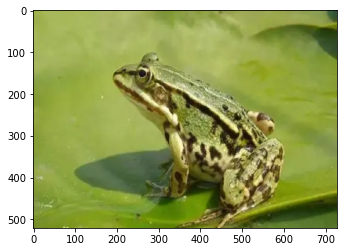

In [2]:
plt.figure()
frog = plt.imread(r"C:\Users\pc\Desktop\frog.png")
fig = plt.imshow(frog)

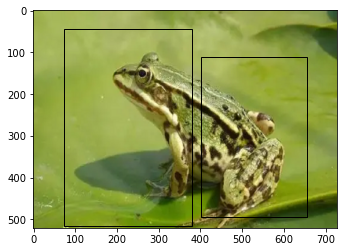

In [24]:
test1 = nms_personal(X,cls_preds,off_anchors_preds,anchors,device=torch.device("cpu"),threshold_nms=0.5)
plt.figure()
frog = plt.imread(r"C:\Users\pc\Desktop\frog.png")
fig = plt.imshow(frog)
for i in range(test1.shape[1]):
    rect = plt.Rectangle(xy=(test1[0,i,2],test1[0,i,3]),height=test1[0,i,5]-test1[0,i,3],width=test1[0,i,4]-test1[0,i,2],fill=False)
    fig.axes.add_patch(rect)

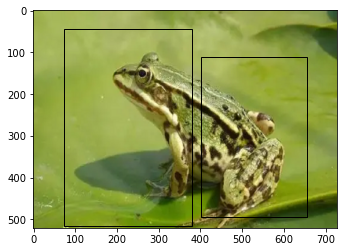

In [19]:
test2 = nms_Li(X,cls_preds,off_anchors_preds,anchors,device=torch.device("cpu"),threshold_nms=0.5)
plt.figure()
frog = plt.imread(r"C:\Users\pc\Desktop\frog.png")
fig = plt.imshow(frog)
for i in range(test2.shape[1]):
    rect = plt.Rectangle(xy=(test2[0,i,2],test2[0,i,3]),height=test2[0,i,5]-test2[0,i,3],width=test2[0,i,4]-test2[0,i,2],fill=False)
    fig.axes.add_patch(rect)